### Importing required modules

In [1]:
### Importing basic libraries
import numpy as np
import torch
from matplotlib import pyplot as plt
import random
import pandas as pd
import scipy
from scipy.signal import butter, sosfiltfilt
import os
import pickle

### Importing torch related libraries
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

### Importing Custom Libraries
from lib.DTnet import SmallIncUNet
from lib.plot_utils import plot_filter_result
from lib.plot_utils import visualize_ecg_and_peaks
from lib.metrics import compute_peak_mae_on_loader

In [2]:
# Paths
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
preproc_path = os.path.join(cache_dir, "data_preprocessed_full.pkl")

duration_sec = 10
frequency = 500

use_hr_band_filter = True
lowcut=0.1
highcut=16

subj_all = [29, 40, 23, 27, 28, 30, 33, 35, 36, 39, 45, 47, 49, 52, 57, 58, 62, 63, 64, 66, 69, 71, 73, 76, 82, 84, 88, 89, 90, 93, 95, 97, 98, 99, 100, 101, 103, 104, 105, 113, 117, 119, 120, 121,  106,  109, 110, 111,  112 ]  #41  118 107

test_subj = subj_all[0:10]
val_subj = subj_all[10:15]
train_subjects = [s for s in subj_all if s not in test_subj and s not in val_subj]

use_augmentation = False
warp_factor_range = (0.85, 1.15)
aug_segment_duration = round(warp_factor_range[1] * duration_sec)       # seconds (larger than target to allow warping)
n_augmented_per_segment = 5
train_overlap = 0.0

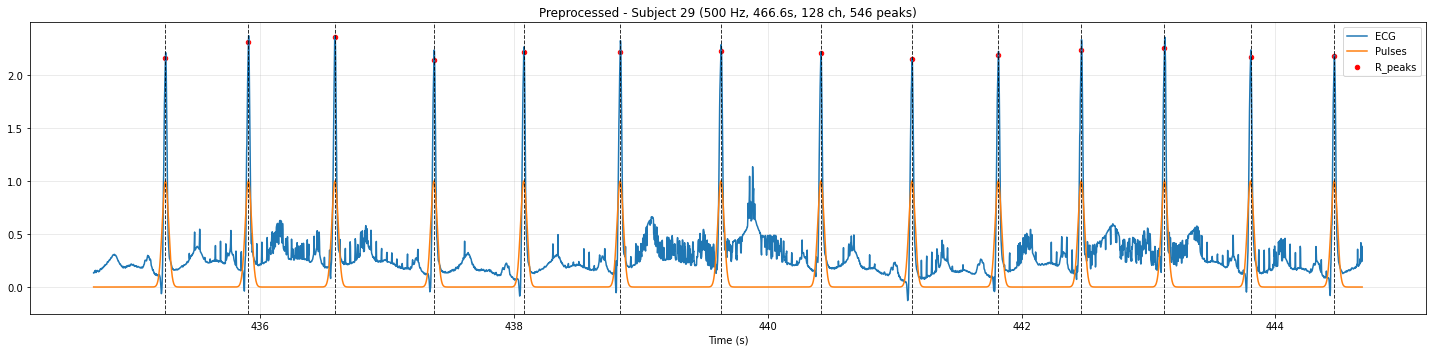

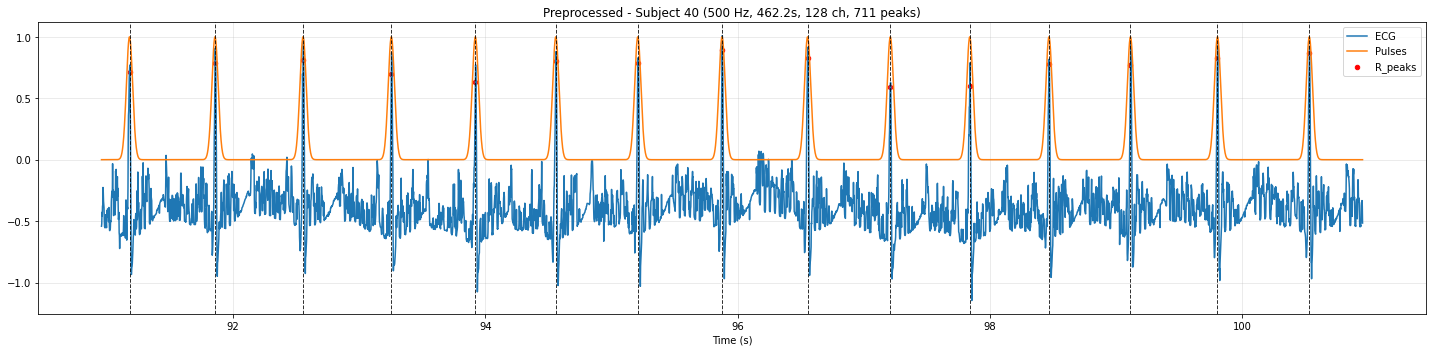

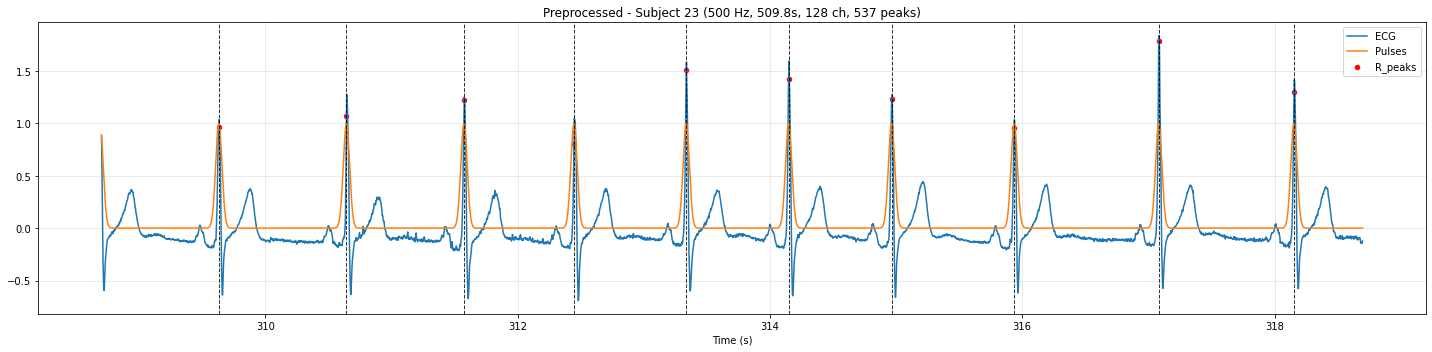

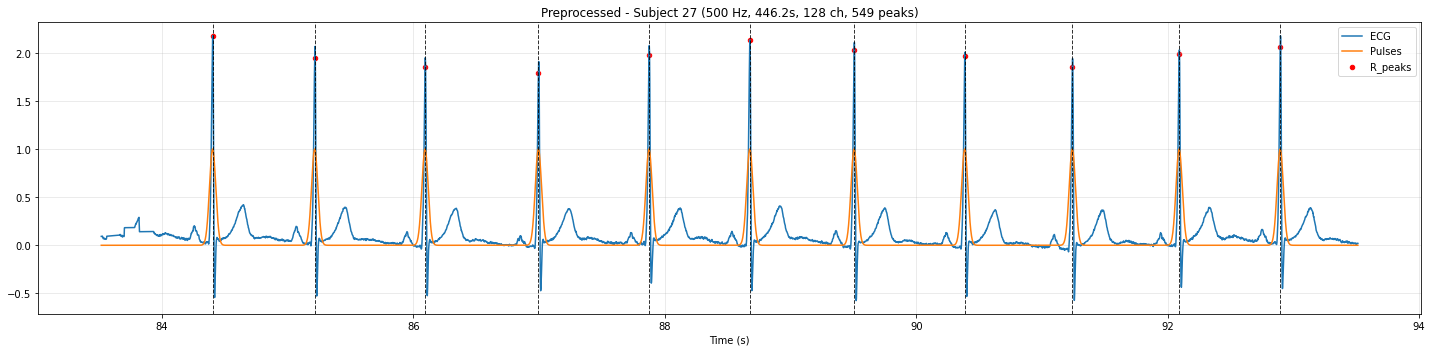

In [3]:
def bandpass_eeg(x, fs, lowcut=0.1, highcut=22.5, order=4):
    nyq = fs / 2.0
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sosfiltfilt(sos, x, axis=-1)


'''
 Preprocess data structure: {
        'ECG': ECG,
        'ECG_pulse': ECG_pulse,
        'R_peaks': R_peaks,
        'EEG': EEG,
        'time': time,
        'freq': freq }
 '''

with open(preproc_path, "rb") as f:
    data_preprocessed = pickle.load(f)

if use_hr_band_filter:
    for ss in subj_all:
        fs_ds = frequency
        eeg_unfilt = np.asarray(data_preprocessed[ss]['EEG'], dtype=float)
        data_preprocessed[ss]['EEG_unfilt'] = eeg_unfilt
        data_preprocessed[ss]['EEG'] = bandpass_eeg(eeg_unfilt, fs_ds, lowcut=lowcut, highcut=highcut)


def compute_R_distance_next(r_peaks, sig_len):
    r_peaks = np.asarray(r_peaks, dtype=int)
    dist = np.full(sig_len, np.nan, dtype=float)

    for i in range(r_peaks.size - 1):
        a = r_peaks[i]
        b = r_peaks[i + 1]
        if b <= a:
            continue
        seg = np.arange(a, b + 1)
        left = seg - a
        right = b - seg
        min_dist = np.minimum(left, right).astype(float)  # 0..(b-a)/2
        interval = float(b - a)  # interval length in samples
        # We want midpoint value == interval (distance to next peak)
        # min_dist at midpoint == interval/2, so multiply by 2:
        values = 2.0 * min_dist  # ranges 0 .. interval
        dist[a:b+1] = values

    # before first peak: use interval to next peak
    first = r_peaks[0]
    if first > 0:
        next_interval = float(r_peaks[1] - r_peaks[0]) if r_peaks.size > 1 else float(sig_len)
        seg = np.arange(0, first)
        # distance to next peak decreases as we approach the peak: use (first - pos)
        d = first - seg  # ranges next_interval..1 (but might be > next_interval if first large)
        # Clip to next_interval so far-away values don't exceed the interval value
        values = np.minimum(d, next_interval)
        # But to be consistent with interior segments shape, scale so maximum equals next_interval
        # If we want linear from 0 at first to next_interval at far left:
        if first > 0:
            values = (d / float(first)) * next_interval
        dist[0:first] = values

    # after last peak: use interval to previous peak
    last = r_peaks[-1]
    if last < sig_len - 1:
        prev_interval = float(r_peaks[-1] - r_peaks[-2]) if r_peaks.size > 1 else float(last + 1)
        seg = np.arange(last + 1, sig_len)
        d = seg - last  # 1..(sig_len-last-1)
        if (sig_len - 1 - last) > 0:
            values = (d / float(sig_len - 1 - last)) * prev_interval
        else:
            values = np.minimum(d, prev_interval)
        dist[last+1:] = values

    return dist


for ss in subj_all:
    r_peaks = data_preprocessed[ss].get('R_peaks', [])
    sig_len = int(np.asarray(data_preprocessed[ss]['ECG']).shape[-1])
    #data_preprocessed[ss]['ECG_pulse'] = compute_R_distance_next(r_peaks, sig_len) / frequency  # distance in second

# Visualize parsed data
for i, ss in enumerate(subj_all):
    visualize_ecg_and_peaks(ss, None, data_preprocessed[ss], duration_sec)
    if i > 2:
        break

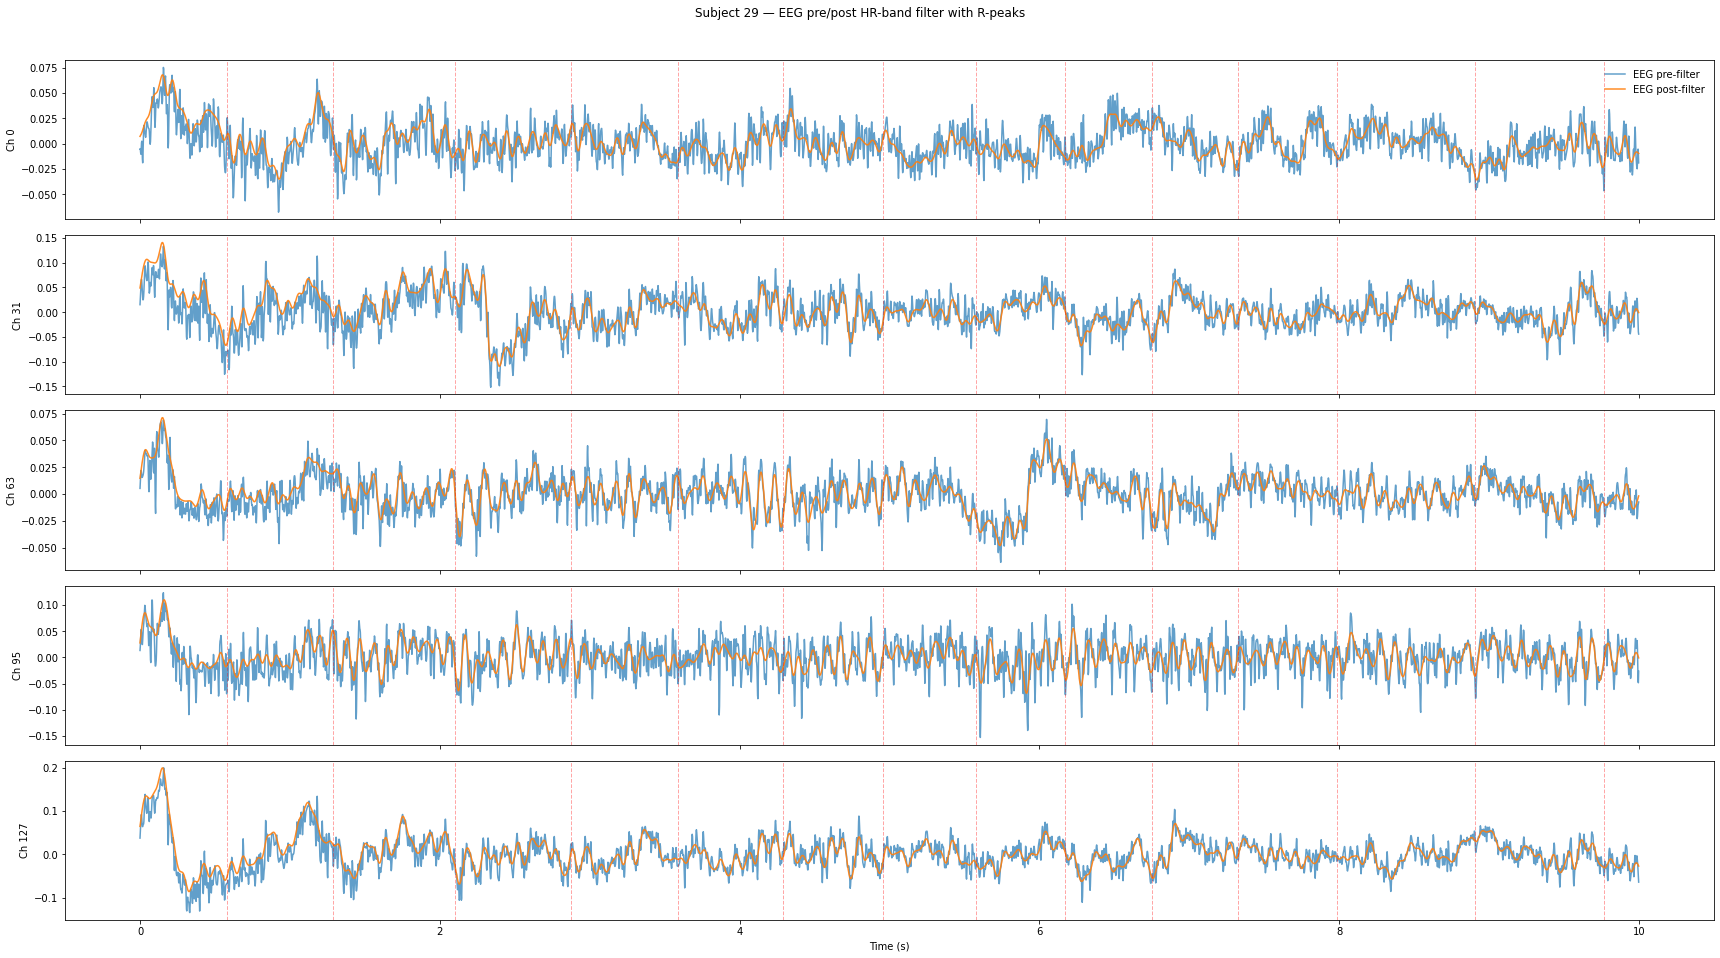

In [4]:
plot_subj = test_subj[0]
plot_filter_result(data_preprocessed, duration_sec, plot_subj)

In [5]:
import numpy as np
from lib.dataset_utils import create_segments_nonoverlapping, create_segments_sliding, create_training_segments_with_augmentation

def process_subjects(subjects, data_preprocessed, seg_len, stage, **aug_params):
    """Process subjects and create segments."""
    X_list, y_list, ecg_list, ids_list = [], [], [], []
    
    for subj_id in subjects:        
        # Choose segmentation method
        if stage == 'training' and aug_params.get('use_augmentation'):
            X, y, ecg = create_training_segments_with_augmentation(
                data_preprocessed[subj_id], 
                aug_params['aug_seg_len'], 
                seg_len, 
                aug_params['train_stride'],
                aug_params['warp_factor_range'], 
                aug_params['n_augmented_per_segment']
            )
        elif stage == 'training':
            X, y, ecg = create_segments_sliding(
                data_preprocessed[subj_id]['EEG'],
                data_preprocessed[subj_id]['ECG_pulse'],
                data_preprocessed[subj_id]['ECG'],
                seg_len, aug_params['train_stride']
            )
        else:
            X, y, ecg = create_segments_nonoverlapping(
                data_preprocessed[subj_id]['EEG'],
                data_preprocessed[subj_id]['ECG_pulse'],
                data_preprocessed[subj_id]['ECG'],
                seg_len
            )
        
        X_list.append(X)
        y_list.append(y)
        ecg_list.append(ecg)
        ids_list.append(np.full(X.shape[0], subj_id, dtype=np.int32))
    
    return X_list, y_list, ecg_list, ids_list


# Calculate parameters
seg_len = int(duration_sec * frequency)
aug_seg_len = int(aug_segment_duration * frequency) if use_augmentation else seg_len
train_stride = max(1, int(seg_len * (1.0 - train_overlap)))
n_channels = data_preprocessed[subj_all[0]]['EEG'].shape[0]

# Process all splits
aug_params = {
    'use_augmentation': use_augmentation,
    'aug_seg_len': aug_seg_len,
    'train_stride': train_stride,
    'warp_factor_range': warp_factor_range,
    'n_augmented_per_segment': n_augmented_per_segment
}

X_train_list, y_train_list, ecg_train_list, train_ids = process_subjects(train_subjects, data_preprocessed, seg_len, 'training', **aug_params)

X_val_list, y_val_list, ecg_val_list, val_ids = process_subjects(val_subj, data_preprocessed, seg_len, 'validation', **aug_params)

X_test_list, y_test_list, ecg_test_list, test_ids = process_subjects(test_subj, data_preprocessed, seg_len, 'test', **aug_params)

# Concatenate all
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
ECG_train = np.concatenate(ecg_train_list, axis=0)
train_seg_subjects = np.concatenate(train_ids, axis=0)

X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
ECG_val = np.concatenate(ecg_val_list, axis=0)
val_seg_subjects = np.concatenate(val_ids, axis=0)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)
ECG_test = np.concatenate(ecg_test_list, axis=0)
test_seg_subjects = np.concatenate(test_ids, axis=0)


def scale_window_standard(x_win):
    # x_win: (channels, window_len) -> z-score per channel
    mean = x_win.mean(axis=1, keepdims=True)
    std = x_win.std(axis=1, keepdims=True) + 1e-8
    return (x_win - mean) / std

X_train = scale_window_standard(X_train)
X_val = scale_window_standard(X_val)
X_test = scale_window_standard(X_test)


# Summary
print(f"Final dataset:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")

Final dataset:
  Train: (1465, 5000, 128)
  Val:   (224, 5000, 128)
  Test:  (455, 5000, 128)


# Train and Evaluate #

### Hyperparameters and Related parameters

In [6]:
BATCH_SIZE = 16
C,H,W = 128, 1, 5000
learn_rate = 1e-3
weight_decay = 0.0
num_epochs = 50

### Loading data via the pt files

In [7]:
# Create PyTorch datasets and loaders
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))
ECG_train_t = torch.from_numpy(ECG_train.astype(np.float32))

X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))
ECG_val_t = torch.from_numpy(ECG_val.astype(np.float32))

X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))
ECG_test_t = torch.from_numpy(ECG_test.astype(np.float32))

y_train_t = y_train_t.unsqueeze(1)
y_val_t = y_val_t.unsqueeze(1)
y_test_t = y_test_t.unsqueeze(1)

# Include ECG in the datasets
train_ds = TensorDataset(X_train_t, y_train_t, ECG_train_t)
val_ds = TensorDataset(X_val_t, y_val_t, ECG_val_t)
test_ds = TensorDataset(X_test_t, y_test_t, ECG_test_t)

trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(val_ds, batch_size=64, shuffle=False)
valloader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Created data loaders with training batch_size={BATCH_SIZE}")
print(X_train_t.shape, y_train_t.shape)
print(X_val_t.shape, y_val_t.shape)
print(X_test_t.shape, y_test_t.shape)

Created data loaders with training batch_size=16
torch.Size([1465, 5000, 128]) torch.Size([1465, 1, 5000])
torch.Size([224, 5000, 128]) torch.Size([224, 1, 5000])
torch.Size([455, 5000, 128]) torch.Size([455, 1, 5000])


### Ensuring deterministicity through Random seeding


In [8]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
manualSeed = 4
random.seed(manualSeed)
torch.manual_seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(manualSeed) 

### Setting the optimizer and Loss function

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SmallIncUNet(in_shape = (C,H,W)).to(device)
optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=weight_decay)

# Use peak-based MAE for LR reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
criterion = nn.MSELoss() #nn.SmoothL1Loss()

summary(model, input_size=(1, seg_len, n_channels), col_names=["input_size", "output_size", "num_params"], depth=4)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
SmallIncUNet                             [1, 5000, 128]            [1, 1, 5000]              --
├─Sequential: 1-1                        [1, 128, 5000]            [1, 32, 2500]             --
│    └─Conv1d: 2-1                       [1, 128, 5000]            [1, 32, 2500]             16,416
│    └─BatchNorm1d: 2-2                  [1, 32, 2500]             [1, 32, 2500]             64
│    └─LeakyReLU: 2-3                    [1, 32, 2500]             [1, 32, 2500]             --
│    └─IncResBlock: 2-4                  [1, 32, 2500]             [1, 32, 2500]             --
│    │    └─Conv1d: 3-1                  [1, 32, 2500]             [1, 32, 2500]             1,024
│    │    └─Sequential: 3-2              [1, 32, 2500]             [1, 8, 2500]              --
│    │    │    └─Conv1d: 4-1             [1, 32, 2500]             [1, 8, 2500]              3,848
│    │    │    └─BatchNor

### Training ###

In [20]:
from lib.metrics import evaluate, extract_peaks_from_distance_transform


epoch_loss = []
test_epoch_loss = []
val_epoch_loss = []

f1_val_history = []
f1_train_history = []
f1_test_history = []

max_val_f1 = 0
patience_counter = 0
early_stop_patience = 20



def compute_peak_mae_on_loader(dataset_loader, model, device, height_threshold=-0.2):
    """
    Compute peak-based MAE (and HRV errors) for a given data loader.
    """
    model.eval()
    all_mae = []
    all_precision = []
    all_recall = []
    all_f1 = []
    all_mrr_err = []
    all_prr50_err = []
    all_sdrr_err = []
    all_rmssd_err = []

    with torch.no_grad():
        for x, y, _ in dataset_loader:
            x = x.to(device)
            y_pred = model(x).cpu().numpy()
            y_true = y.cpu().numpy()

            for i in range(y_pred.shape[0]):
                pred_dist = y_pred[i, 0, :]
                true_dist = y_true[i, 0, :]

                pred_peaks = extract_peaks_from_distance_transform(-pred_dist, min_distance=200, height_threshold=height_threshold)
                true_peaks = extract_peaks_from_distance_transform(-true_dist, min_distance=200, height_threshold=height_threshold)

                res = evaluate(pred_peaks, true_peaks)

                all_mae.append(res["mae"])
                all_precision.append(res["precision"])
                all_recall.append(res["recall"])
                all_f1.append(res["f1"])
                all_mrr_err.append(res["mrr_error"])
                all_prr50_err.append(res["prr50_error"])
                all_sdrr_err.append(res["sdrr_error"])
                all_rmssd_err.append(res["rmssd_error"])

    return (
        np.mean(all_mae),
        len(all_mae),
        np.mean(all_precision),
        np.mean(all_recall),
        np.mean(all_f1),
        np.mean(all_mrr_err),
        np.mean(all_prr50_err),
        np.mean(all_sdrr_err),
        np.mean(all_rmssd_err),
    )


for epoch in range(num_epochs):
    model.train()
    net_loss_sum = 0.0
    for step,(x,y,ecg) in enumerate(trainloader):  
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        net_loss_sum += loss.item()
    train_loss_scalar = net_loss_sum / (step + 1)
    epoch_loss.append(train_loss_scalar)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        net_test_sum = 0.0
        for step,(x,y,ecg) in enumerate(testloader): 
            x = x.to(device)
            y = y.to(device)
            y_pred_t = model(x)
            test_loss = criterion(y_pred_t, y)
            net_test_sum += test_loss.item()
        test_loss_scalar = net_test_sum / (step + 1)
    test_epoch_loss.append(test_loss_scalar)
    
    # Evaluate on validation set (loss-based)
    with torch.no_grad():
        net_val_sum = 0.0
        for step,(x,y,ecg) in enumerate(valloader):  
            x = x.to(device)
            y = y.to(device)
            y_pred_v = model(x)
            val_loss = criterion(y_pred_v, y)
            net_val_sum += val_loss.item()
        val_loss_scalar = net_val_sum / (step + 1)
    val_epoch_loss.append(val_loss_scalar)
    
    # Compute peak-based MAE on validation set
    val_peak_mae, _val_num_matches, val_precision, val_recall, val_f1, mrr_err_val, prr50_err_val, sdrr_err_val, rmssd_err_val  = compute_peak_mae_on_loader(valloader, model, device, height_threshold=0.25)
    f1_val_history.append(val_f1)
    
    # Use peak-based MAE for scheduler and early stopping
    if not np.isnan(val_f1):
        scheduler.step(1-val_f1)

    # Compute peak-based MAE on validation set
    train_peak_mae, _num_matches, train_precision, train_recall, train_f1, mrr_err_train, prr50_err_train, sdrr_err_train, rmssd_err_train = compute_peak_mae_on_loader(trainloader, model, device, height_threshold=0.25)
    f1_train_history.append(train_f1)

    # Compute peak-based MAE on validation set
    test_peak_mae, _num_matches, test_precision, test_recall, test_f1, mrr_err_test, prr50_err_test, sdrr_err_test, rmssd_err_test = compute_peak_mae_on_loader(testloader, model, device, height_threshold=0.25)
    f1_test_history.append(test_f1)

    print(
        f"Epoch {epoch+1:3d}/{num_epochs:<3d} | "
        f"Losses  Tr: {train_loss_scalar:.4f}  V: {val_loss_scalar:.4f}  Ts: {test_loss_scalar:.4f} | "
        f"LR: {optimizer.param_groups[0]['lr']:.2e}\n"
        f"Train | P: {train_precision:.2f}, R: {train_recall:.2f}, F1: {train_f1:.4f}, "
        f"MAE: {train_peak_mae:.4f}, mRR_err: {mrr_err_train:.2f}%, "
        f"pRR50_err: {prr50_err_train:.2f}%, SDRR_err: {sdrr_err_train:.2f}%, RMSSD_err: {rmssd_err_train:.2f}%\n"
        f"Val   | P: {val_precision:.2f}, R: {val_recall:.2f}, F1: {val_f1:.4f}, "
        f"MAE: {val_peak_mae:.4f}, mRR_err: {mrr_err_val:.2f}%, "
        f"pRR50_err: {prr50_err_val:.2f}%, SDRR_err: {sdrr_err_val:.2f}%, RMSSD_err: {rmssd_err_val:.2f}%\n"
        f"Test  | P: {test_precision:.2f}, R: {test_recall:.2f}, F1: {test_f1:.4f}, "
        f"MAE: {test_peak_mae:.4f}, mRR_err: {mrr_err_test:.2f}%, "
        f"pRR50_err: {prr50_err_test:.2f}%, SDRR_err: {sdrr_err_test:.2f}%, RMSSD_err: {rmssd_err_test:.2f}%"
    )

    # Save best model based on peak-based MAE
    if not np.isnan(val_f1) and val_f1 > max_val_f1:
        max_val_f1 = val_f1
        patience_counter = 0
        print(f'++++++++++++++++++++++++++++++++++')
        torch.save(model.state_dict(), 'saved_model/best_model.pt')
    else:
        patience_counter += 1
        print(f'---------------------------------- {patience_counter}/{early_stop_patience}')
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f'Early stopping triggered at epoch {epoch+1}')
        break

print(f'\nTraining completed. Best val F1: {max_val_f1:.4f} samples')
model.load_state_dict(torch.load('saved_model/best_model.pt'))

Epoch   1/50  | Losses  Tr: 0.2069  V: 0.0535  Ts: 0.0525 | LR: 1.00e-03
Train | P: 0.56, R: 0.19, F1: 0.2686, MAE: 0.1769, mRR_err: nan%, pRR50_err: 71.57%, SDRR_err: nan%, RMSSD_err: nan%
Val   | P: 0.56, R: 0.18, F1: 0.2656, MAE: 0.1891, mRR_err: nan%, pRR50_err: 64.03%, SDRR_err: nan%, RMSSD_err: nan%
Test  | P: 0.55, R: 0.18, F1: 0.2646, MAE: 0.1969, mRR_err: nan%, pRR50_err: 66.78%, SDRR_err: nan%, RMSSD_err: nan%
++++++++++++++++++++++++++++++++++
Epoch   2/50  | Losses  Tr: 0.0552  V: 0.0523  Ts: 0.0509 | LR: 1.00e-03
Train | P: 0.40, R: 0.04, F1: 0.0768, MAE: 0.1069, mRR_err: nan%, pRR50_err: 19.20%, SDRR_err: nan%, RMSSD_err: nan%
Val   | P: 0.38, R: 0.04, F1: 0.0751, MAE: 0.1179, mRR_err: nan%, pRR50_err: 23.79%, SDRR_err: nan%, RMSSD_err: nan%
Test  | P: 0.37, R: 0.04, F1: 0.0657, MAE: 0.0992, mRR_err: nan%, pRR50_err: 20.26%, SDRR_err: nan%, RMSSD_err: nan%
---------------------------------- 1/20
Epoch   3/50  | Losses  Tr: 0.0537  V: 0.0524  Ts: 0.0507 | LR: 1.00e-03
Trai

<All keys matched successfully>

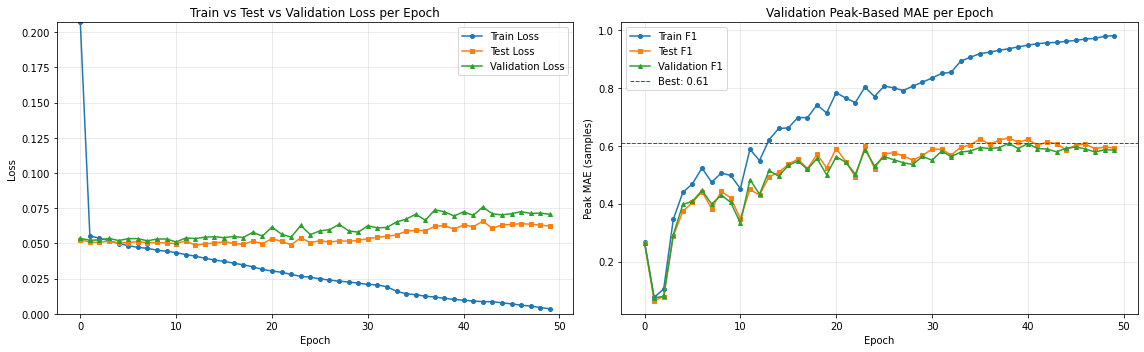

In [21]:
# Plot training curves
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss curves
axes[0].plot(epoch_loss, label='Train Loss', marker='o', markersize=4)
axes[0].plot(test_epoch_loss, label='Test Loss', marker='s', markersize=4)
axes[0].plot(val_epoch_loss, label='Validation Loss', marker='^', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train vs Test vs Validation Loss per Epoch')
axes[0].grid(alpha=0.3)
axes[0].legend()
axes[0].set_ylim(0, max(0.06, max(epoch_loss[:3]) if len(epoch_loss) > 0 else 0.06))

# Peak MAE curve
axes[1].plot(f1_train_history, label='Train F1', marker='o', markersize=4)
axes[1].plot(f1_test_history, label='Test F1', marker='s', markersize=4)
axes[1].plot(f1_val_history, label='Validation F1', marker='^', markersize=4)

axes[1].axhline(max_val_f1, color='red', linestyle='--', linewidth=1, label=f'Best: {max_val_f1:.2f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Peak MAE (samples)')
axes[1].set_title('Validation Peak-Based MAE per Epoch')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

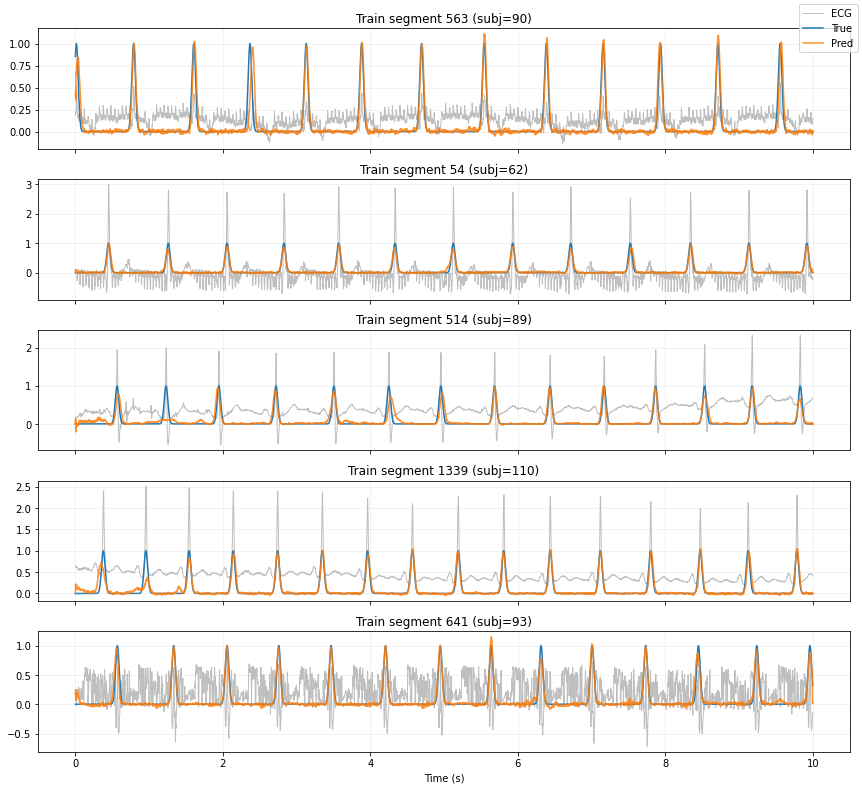

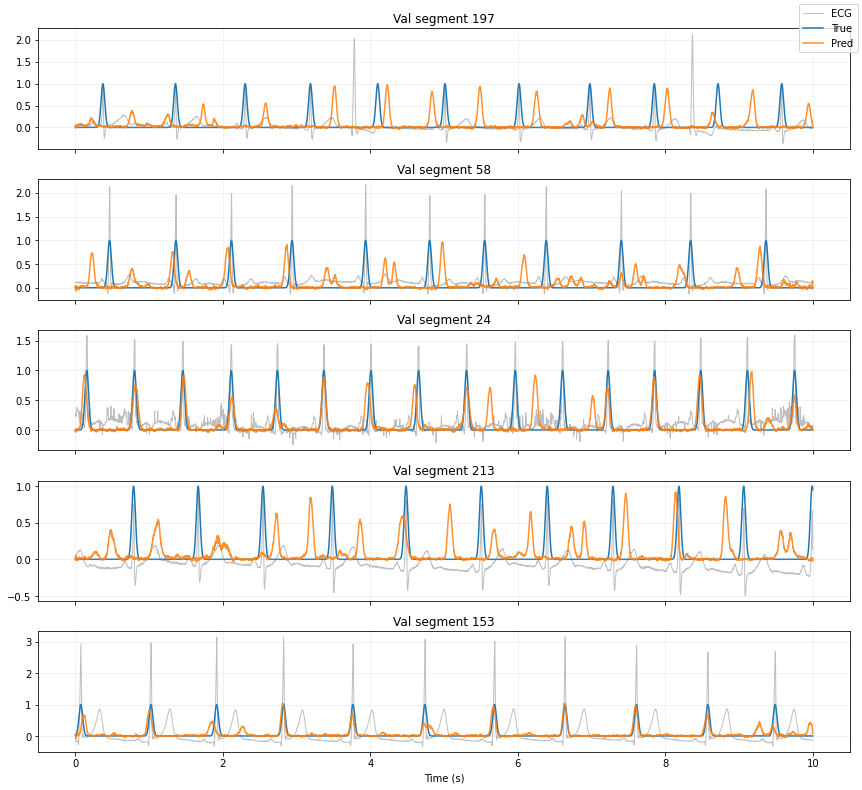

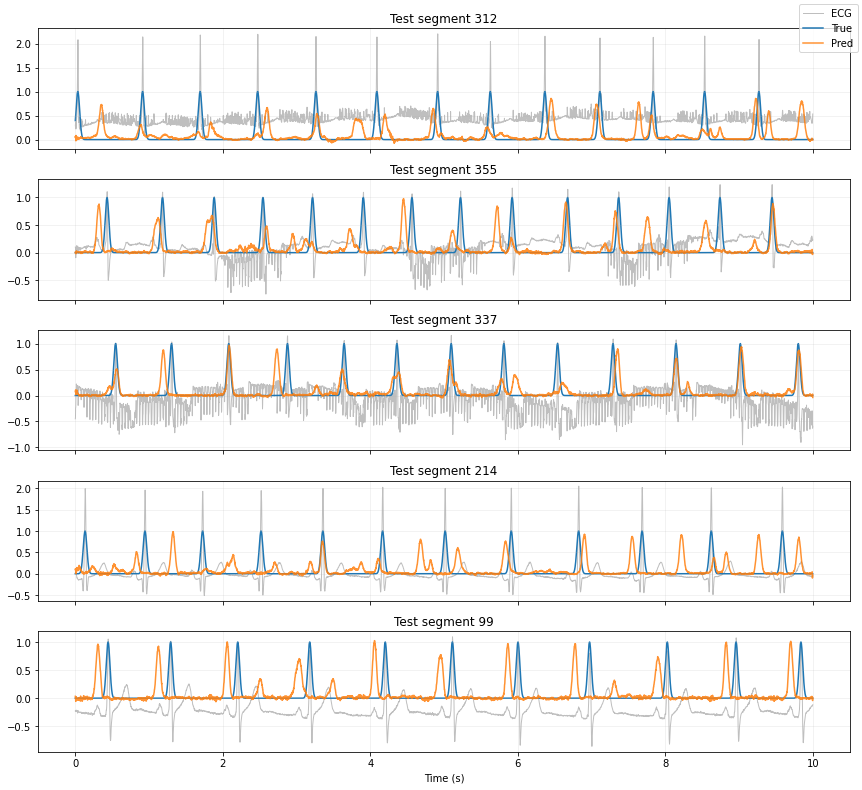

In [22]:
from lib.plot_utils import visualize_predictions

visualize_predictions('Train', X_train, y_train, ECG_train, model, seg_len, frequency, device, train_seg_subjects, k=5)
visualize_predictions('Val', X_val, y_val, ECG_val, model, seg_len, frequency, device, k=5)
visualize_predictions('Test', X_test, y_test, ECG_test, model, seg_len, frequency, device, k=5)


TEST SET Peak Detection Examples:


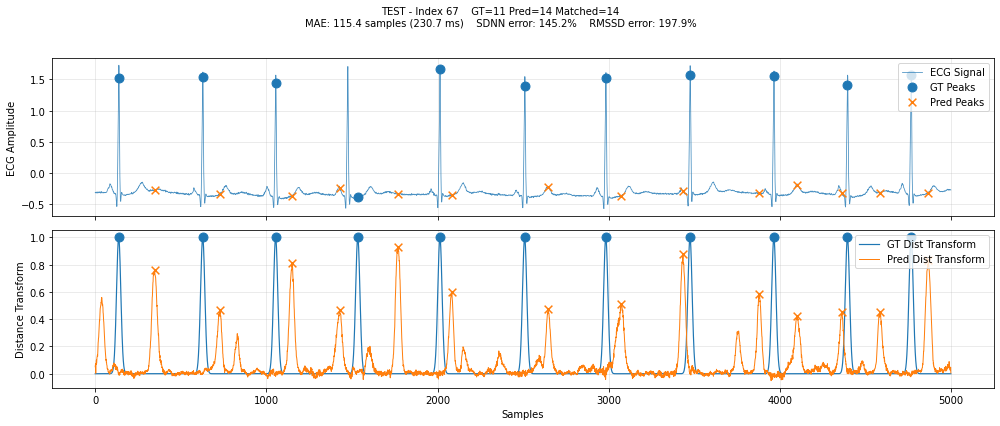

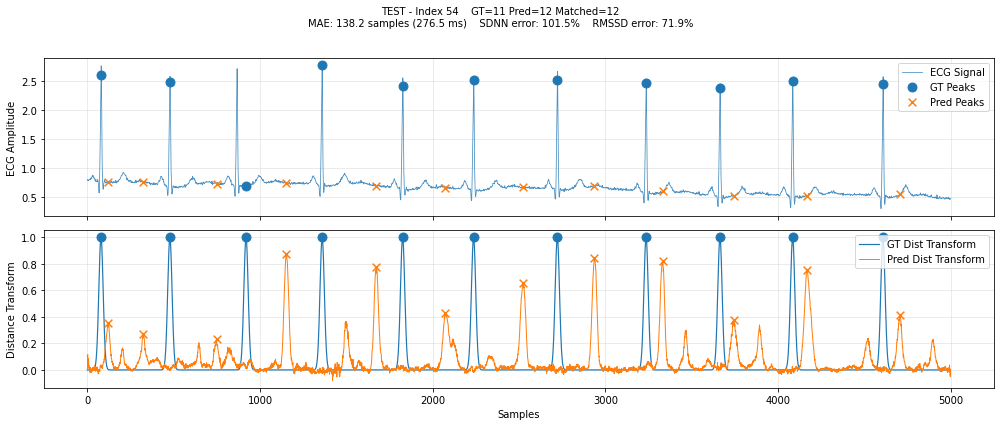

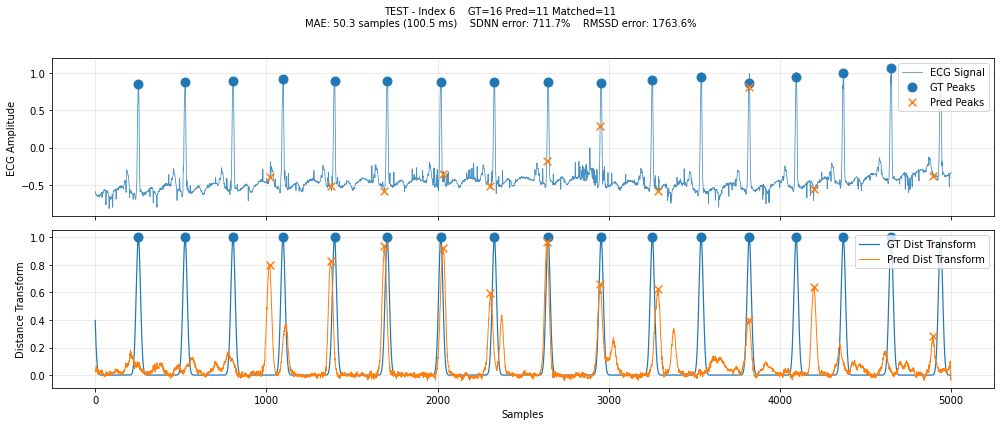

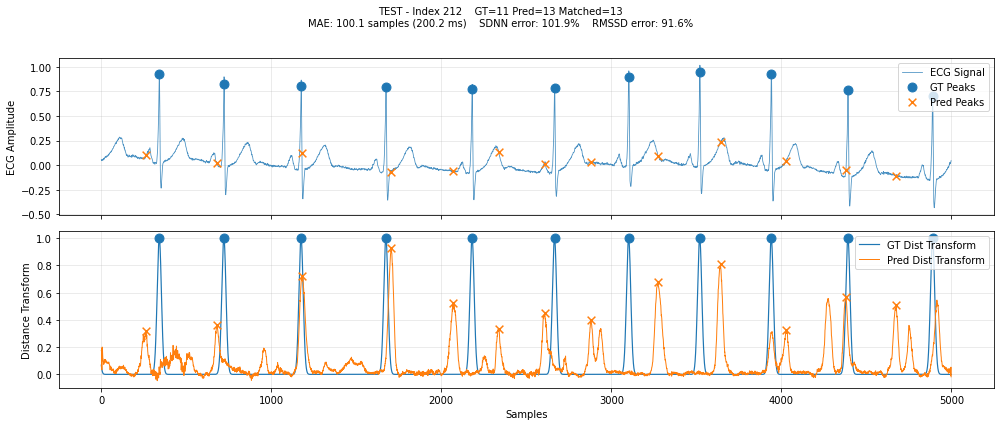

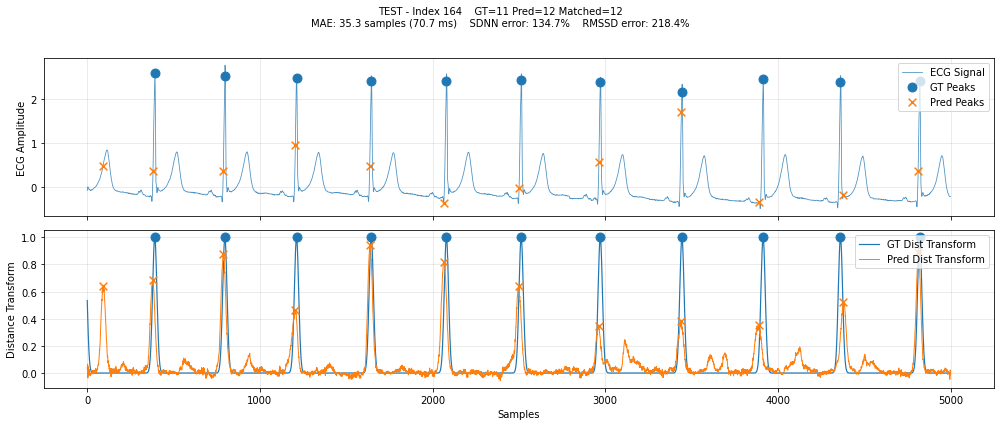

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from lib.metrics import min_distance_from_pred_to_true

def _rr_ms(peaks, fs):
    return np.diff(np.sort(peaks)) / float(fs) * 1000.0

def _sdnn_rmssd_from_peaks(peaks, fs):
    rr = _rr_ms(peaks, fs)
    sdnn = np.std(rr, ddof=1)  # use sample std
    rmssd = np.sqrt(np.mean(np.diff(rr)**2)) 
    return sdnn, rmssd

def visualize_peak_detection(dataset_loader, model, device, n_samples=10, dataset_name="Dataset", fs=500):
    """
    Visualize peak detection on random samples and show MAE + % errors (SDNN, RMSSD) above each plot.
    """
    model.eval()
    dataset = dataset_loader.dataset
    ds_len = len(dataset)
    rand_idxs = random.sample(range(ds_len), min(n_samples, ds_len))
    
    x_list, y_list, ecg_list = [], [], []
    for idx in rand_idxs:
        item = dataset[idx]
        x_list.append(item[0])
        y_list.append(item[1])
        ecg_list.append(item[2])

    
    xb = torch.stack(x_list, dim=0)
    ecg = torch.stack(ecg_list, dim=0)
    yb = torch.stack(y_list, dim=0)
    
    with torch.no_grad():
        xb_gpu = xb.to(device)
        pred = model(xb_gpu).cpu().numpy()
        y_true = yb.cpu().numpy()
        ecg = ecg.cpu().numpy()
    
    for i, ds_idx in enumerate(rand_idxs):
        pred_dist = pred[i, 0, :]
        true_dist = y_true[i, 0, :]
        ecg_signal = ecg[i, :]
        
        # Extract peaks
        pred_peaks = extract_peaks_from_distance_transform(-pred_dist, min_distance=200, height_threshold=0.2, prominence=0.02)
        pred_peaks = [elem for elem in pred_peaks if 50 < elem < 4900]

        true_peaks = extract_peaks_from_distance_transform(-true_dist, min_distance=200, height_threshold=0.2, prominence=0.02)
        true_peaks = [elem for elem in true_peaks if 50 < elem < 4900]

        distances = min_distance_from_pred_to_true(pred_peaks, true_peaks)

        # Match peaks -> distances in samples
        distances = min_distance_from_pred_to_true(pred_peaks, true_peaks)
        mae_samples = np.mean(distances) if len(distances) > 0 else np.nan
        mae_ms = mae_samples / float(fs) * 1000.0 if not np.isnan(mae_samples) else np.nan
        
        # HRV metrics for this sample
        sdnn_t, rmssd_t = _sdnn_rmssd_from_peaks(true_peaks, fs)
        sdnn_p, rmssd_p = _sdnn_rmssd_from_peaks(pred_peaks, fs)

        # percent errors (absolute)
        pct_sdnn = (abs(sdnn_p - sdnn_t) / abs(sdnn_t) * 100.0) if sdnn_t != 0 else np.nan
        pct_rmssd = (abs(rmssd_p - rmssd_t) / abs(rmssd_t) * 100.0) if rmssd_t != 0 else np.nan
        
        # Create figure
        fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
        
        # Top: ECG + peaks
        axes[0].plot(ecg_signal, linewidth=0.8, alpha=0.8, label='ECG Signal')
        axes[0].scatter(true_peaks, ecg_signal[true_peaks], marker='o', s=80, label='GT Peaks', zorder=5)
        axes[0].scatter(pred_peaks, ecg_signal[pred_peaks], marker='x', s=60, label='Pred Peaks', zorder=5)
        axes[0].set_ylabel('ECG Amplitude')
        axes[0].legend(loc='upper right')
        axes[0].grid(alpha=0.3)
        
        # Bottom: distance transforms
        axes[1].plot(true_dist, linestyle='-', linewidth=1.2, label='GT Dist Transform')
        axes[1].plot(pred_dist, linestyle='-', linewidth=1.0, label='Pred Dist Transform')
        axes[1].scatter(true_peaks, true_dist[true_peaks], marker='o', s=80, zorder=5)
        axes[1].scatter(pred_peaks, pred_dist[pred_peaks], marker='x', s=60, zorder=5)
        axes[1].set_xlabel('Samples')
        axes[1].set_ylabel('Distance Transform')
        axes[1].legend(loc='upper right')
        axes[1].grid(alpha=0.3)
        
        # Suptitle with MAE and percent errors
        suptitle = (
            f"{dataset_name} - Index {ds_idx}    "
            f"GT={len(true_peaks)} Pred={len(pred_peaks)} Matched={len(distances)}\n"
            f"MAE: {mae_samples:.1f} samples ({mae_ms:.1f} ms)    "
            f"SDNN error: {pct_sdnn:.1f}%    RMSSD error: {pct_rmssd:.1f}%"
        )
        fig.suptitle(suptitle, fontsize=10, y=0.98)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


#print("TRAIN SET Peak Detection Examples:")
#visualize_peak_detection(trainloader, model, device, n_samples=5, dataset_name="TRAIN")

print("\nTEST SET Peak Detection Examples:")
visualize_peak_detection(testloader, model, device, n_samples=5, dataset_name="TEST")

In [24]:
import numpy as np
import torch

def _rr_ms(peaks, fs):
    """RR intervals in ms from sorted peak indices (samples). Assumes >=2 peaks."""
    return np.diff(np.sort(peaks)) / float(fs) * 1000.0

def _sdnn_rmssd_from_peaks(peaks, fs):
    rr = _rr_ms(peaks, fs)
    sdnn = np.std(rr)                    # simple population std
    rmssd = np.sqrt(np.mean(np.diff(rr)**2))
    return sdnn, rmssd

def compute_peak_metrics(dataset_loader, model, device, min_distance=300, fs=500):
    model.eval()
    all_distances = []

    true_sdnn_vals = []
    pred_sdnn_vals = []
    true_rmssd_vals = []
    pred_rmssd_vals = []

    with torch.no_grad():
        for x, y, _ecg in dataset_loader:
            x = x.to(device)
            y_pred = model(x).cpu().numpy()
            y_true = y.cpu().numpy()

            for i in range(y_pred.shape[0]):
                pred_dist = y_pred[i, 0, :]
                true_dist = y_true[i, 0, :]

                pred_peaks = extract_peaks_from_distance_transform(pred_dist, min_distance=min_distance, height_threshold=-0.3)
                true_peaks = extract_peaks_from_distance_transform(true_dist, min_distance=min_distance, height_threshold=-0.3)

                # assume data is good: at least 2 peaks per sample
                sdnn_t, rmssd_t = _sdnn_rmssd_from_peaks(true_peaks, fs)
                sdnn_p, rmssd_p = _sdnn_rmssd_from_peaks(pred_peaks, fs)

                true_sdnn_vals.append(sdnn_t)
                pred_sdnn_vals.append(sdnn_p)
                true_rmssd_vals.append(rmssd_t)
                pred_rmssd_vals.append(rmssd_p)

                # keep your distance matching for MAE/RMSE (unchanged)
                dists = min_distance_from_pred_to_true(pred_peaks, true_peaks)
                if len(dists) > 0:
                    all_distances.extend(dists)

    all_distances = np.array(all_distances)
    mae = np.nan if all_distances.size == 0 else np.mean(all_distances) / float(fs)
    rmse = np.nan if all_distances.size == 0 else np.sqrt(np.mean(all_distances**2)) / float(fs)

    true_sdnn_vals = np.array(true_sdnn_vals)
    pred_sdnn_vals = np.array(pred_sdnn_vals)
    true_rmssd_vals = np.array(true_rmssd_vals)
    pred_rmssd_vals = np.array(pred_rmssd_vals)

    mean_true_sdnn = true_sdnn_vals.mean()
    mean_pred_sdnn = pred_sdnn_vals.mean()
    mean_true_rmssd = true_rmssd_vals.mean()
    mean_pred_rmssd = pred_rmssd_vals.mean()

    pct_err_sdnn = np.mean(np.abs(pred_sdnn_vals - true_sdnn_vals) / np.abs(true_sdnn_vals)) * 100.0
    pct_err_rmssd = np.mean(np.abs(pred_rmssd_vals - true_rmssd_vals) / np.abs(true_rmssd_vals)) * 100.0

    return {
        'MAE': mae,
        'RMSE': rmse,
        'num_matches': int(len(all_distances)),
        'mean_true_SDNN_ms': mean_true_sdnn,
        'mean_pred_SDNN_ms': mean_pred_sdnn,
        'mean_abs_pct_error_SDNN': pct_err_sdnn,
        'mean_true_RMSSD_ms': mean_true_rmssd,
        'mean_pred_RMSSD_ms': mean_pred_rmssd,
        'mean_abs_pct_error_RMSSD': pct_err_rmssd,
    }


# Compute metrics for train and test sets
print("Computing peak-based metrics for TRAIN set...")
train_metrics = compute_peak_metrics(trainloader, model, device, min_distance=300)

print("Computing peak-based metrics for TEST set...")
test_metrics = compute_peak_metrics(testloader, model, device, min_distance=300)

print("\n" + "="*70)
print("PEAK-BASED METRICS (with biological constraint: min 300 points)")
print("="*70)

# ---- TRAIN ----
print("\nTRAIN SET:")
print(f"  MAE:  {train_metrics['MAE']:.4f} s")
print(f"  RMSE: {train_metrics['RMSE']:.4f} s")
print(f"  Matched peaks: {train_metrics['num_matches']}")

print(f"  SDNN (true):  {train_metrics['mean_true_SDNN_ms']:.2f} ms")
print(f"  SDNN (pred):  {train_metrics['mean_pred_SDNN_ms']:.2f} ms")
print(f"  SDNN % error: {train_metrics['mean_abs_pct_error_SDNN']:.2f}%")

print(f"  RMSSD (true):  {train_metrics['mean_true_RMSSD_ms']:.2f} ms")
print(f"  RMSSD (pred):  {train_metrics['mean_pred_RMSSD_ms']:.2f} ms")
print(f"  RMSSD % error: {train_metrics['mean_abs_pct_error_RMSSD']:.2f}%")

# ---- TEST ----
print("\nTEST SET:")
print(f"  MAE:  {test_metrics['MAE']:.4f} s")
print(f"  RMSE: {test_metrics['RMSE']:.4f} s")
print(f"  Matched peaks: {test_metrics['num_matches']}")

print(f"  SDNN (true):  {test_metrics['mean_true_SDNN_ms']:.2f} ms")
print(f"  SDNN (pred):  {test_metrics['mean_pred_SDNN_ms']:.2f} ms")
print(f"  SDNN % error: {test_metrics['mean_abs_pct_error_SDNN']:.2f}%")

print(f"  RMSSD (true):  {test_metrics['mean_true_RMSSD_ms']:.2f} ms")
print(f"  RMSSD (pred):  {test_metrics['mean_pred_RMSSD_ms']:.2f} ms")
print(f"  RMSSD % error: {test_metrics['mean_abs_pct_error_RMSSD']:.2f}%")

print("="*70)

Computing peak-based metrics for TRAIN set...
Computing peak-based metrics for TEST set...

PEAK-BASED METRICS (with biological constraint: min 300 points)

TRAIN SET:
  MAE:  0.1977 s
  RMSE: 0.2519 s
  Matched peaks: 16307
  SDNN (true):  72.90 ms
  SDNN (pred):  202.81 ms
  SDNN % error: 567.16%
  RMSSD (true):  80.17 ms
  RMSSD (pred):  293.45 ms
  RMSSD % error: 1053.24%

TEST SET:
  MAE:  0.2342 s
  RMSE: 0.2920 s
  Matched peaks: 2450
  SDNN (true):  85.05 ms
  SDNN (pred):  213.61 ms
  SDNN % error: 495.00%
  RMSSD (true):  98.01 ms
  RMSSD (pred):  309.17 ms
  RMSSD % error: 955.74%
